In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import re
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('train.csv')
df

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,89,973,Acer,Chromebook C738T-C2EJ,2 in 1 Convertible,11.6,IPS Panel Touchscreen 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.25kg,389.00
908,716,1018,Toshiba,Portege Z30-C-16H,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.2kg,1195.00
909,517,1071,Acer,Aspire ES1-523,Notebook,15.6,1366x768,AMD A8-Series 7410 2.2GHz,8GB,1TB HDD,AMD Radeon R5,Windows 10,2.4kg,449.00
910,891,965,Dell,Latitude 7480,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 7600U 2.8GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.36kg,1775.00


In [4]:
df['Gpu'].str.split(" ")

0           [AMD, Radeon, R7, M445]
1        [Intel, HD, Graphics, 505]
2        [Intel, HD, Graphics, 520]
3      [Nvidia, GeForce, GTX, 1070]
4        [Intel, HD, Graphics, 520]
                   ...             
907      [Intel, HD, Graphics, 400]
908      [Intel, HD, Graphics, 520]
909               [AMD, Radeon, R5]
910      [Intel, HD, Graphics, 620]
911         [AMD, Radeon, R5, M430]
Name: Gpu, Length: 912, dtype: object

In [5]:
lista_palabras = []

for topic in df['Gpu']:
    for palabra in topic.split(" "):
        lista_palabras.append(palabra.lower())

In [6]:
pd.Series(lista_palabras).value_counts().head(10)

graphics    530
intel       522
hd          465
nvidia      268
geforce     247
620         246
gtx         158
520         150
amd         122
radeon      117
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [8]:
df['Ram'] = df['Ram'].str.replace('GB','').astype(int)
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

In [9]:
df = df.rename(columns={'Ram': 'Ram(GB)', 'Weight': 'Weight(kg)'})

In [10]:
def classify_weight(w):
    if w < 1.2:
        return 'Ultralight'
    elif w < 1.8:
        return 'Light'
    elif w < 2.5:
        return 'Standard'
    else:
        return 'Heavy'

df['Portability'] = df['Weight(kg)'].apply(classify_weight)

In [11]:
def extract_memory_features(mem_str):
    mem_str = mem_str.replace('GB', '').replace('TB', '000')
    ssd = 0
    hdd = 0
    flash = 0

    for part in mem_str.split('+'):
        part = part.strip().lower()

        size_match = re.search(r'(\d+)', part)
        if not size_match:
            continue

        size = int(size_match.group())

        if 'ssd' in part:
            ssd += size
        elif 'hdd' in part:
            hdd += size
        elif 'flash' in part:
            flash += size

    return pd.Series([ssd, hdd, flash])

df[['SSD', 'HDD', 'Flash']] = df['Memory'].apply(extract_memory_features)

In [12]:
def extract_resolution_features(res_str):

    is_touch = int('touch' in res_str.lower())

    match = re.search(r'(\d{3,4})x(\d{3,4})', res_str)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
    else:
        width, height = None, None

    return pd.Series([is_touch, width, height])

df[['Touchscreen', 'ScreenWidth', 'ScreenHeight']] = df['ScreenResolution'].apply(extract_resolution_features)

In [13]:
df['HasIPS'] = df['ScreenResolution'].str.contains('IPS', case=False).astype(int)

In [14]:
def extract_cpu_features(cpu_str):
    cpu_str = str(cpu_str).lower()

    if 'intel' in cpu_str:
        brand = 'Intel'
    elif 'amd' in cpu_str:
        brand = 'AMD'
    else:
        brand = 'Other'

    fam_match = re.search(r'(core i[3579]|ryzen \d)', cpu_str)
    family = fam_match.group(0) if fam_match else 'Other'

    gen_match = re.search(r'core i[3579] (\d)', cpu_str)
    if not gen_match:
        gen_match = re.search(r'ryzen (\d)', cpu_str)
    
    if gen_match:
        generation = int(gen_match.group(1))
    else:
        generation = -1

    speed_match = re.search(r'(\d+\.\d+)ghz', cpu_str)
    speed = float(speed_match.group(1)) if speed_match else 0

    return pd.Series([brand, family, generation, speed])

df[['Cpu_brand', 'Cpu_family', 'Cpu_generation', 'Cpu_speed']] = df['Cpu'].apply(extract_cpu_features)

In [15]:
def extract_gpu_features(gpu_str):
    gpu_str = str(gpu_str).lower()

    if 'nvidia' in gpu_str:
        brand = 'NVIDIA'
    elif 'amd' in gpu_str:
        brand = 'AMD'
    elif 'intel' in gpu_str:
        brand = 'Intel'
    else:
        brand = 'Other'

    model_match = re.search(r'(gtx|rtx|radeon rx|radeon) ?\d{3,4}', gpu_str)
    model = model_match.group(0).strip() if model_match else 'Other'
    
    return pd.Series([brand, model])

df[['Gpu_brand', 'Gpu_model']] = df['Gpu'].apply(extract_gpu_features)

In [16]:
#ordenamos el dataframe
col = 'Price_euros'
cols = [c for c in df.columns if c != col]
cols.append(col)
df = df[cols]

<Axes: >

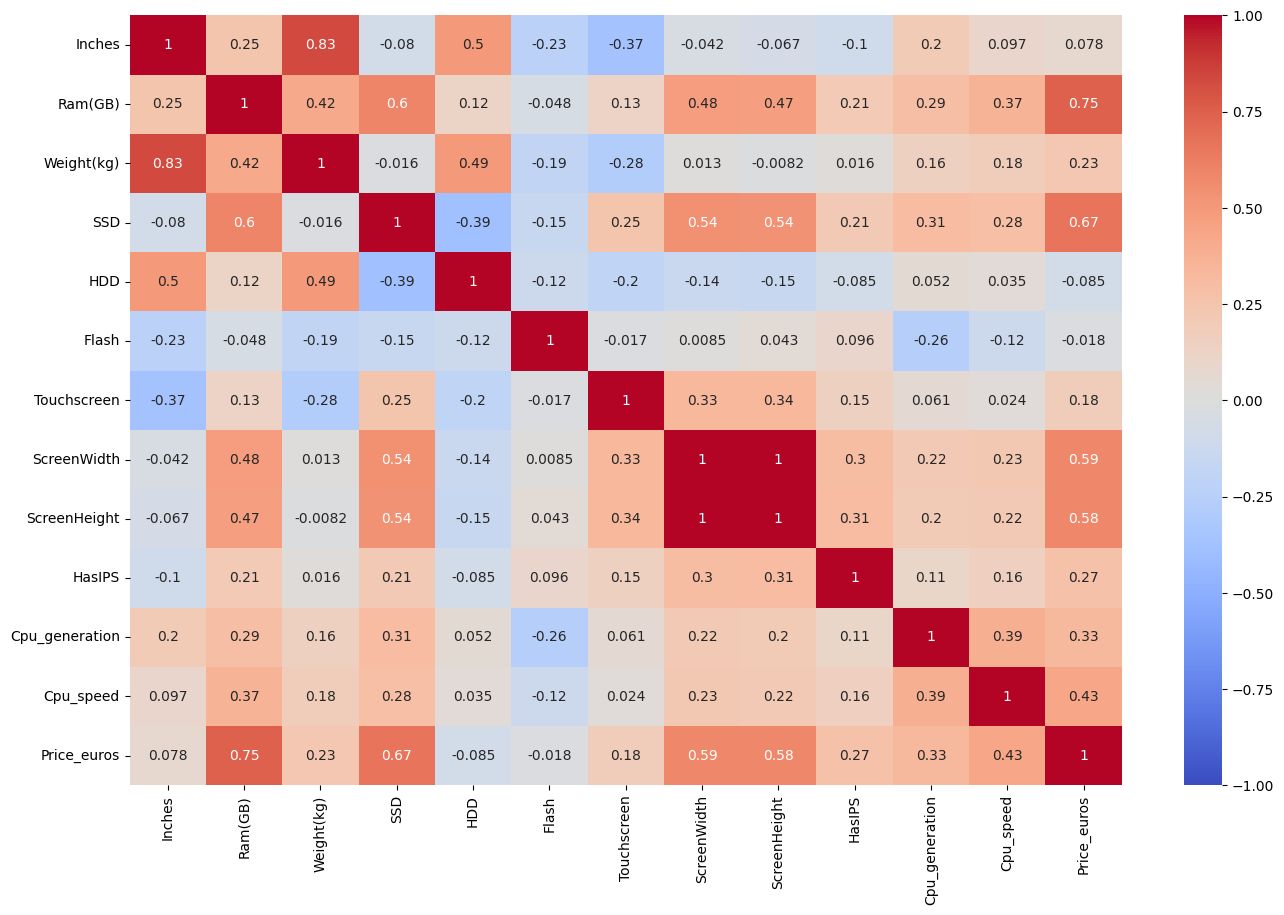

In [17]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(numeric_only=True).drop(['id','laptop_ID'], axis=1).drop(['id','laptop_ID'], axis=0), annot=True, cmap='coolwarm', vmin= -1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram(GB)           912 non-null    int64  
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight(kg)        912 non-null    float64
 13  Portability       912 non-null    object 
 14  SSD               912 non-null    int64  
 15  HDD               912 non-null    int64  
 16  Flash             912 non-null    int64  
 1

In [38]:
cat_cols = ['Company', 'TypeName', 'OpSys', 'Cpu_brand', 'Cpu_family', 'Gpu_brand', 'Gpu_model', 'Portability']
num_cols = ['Ram(GB)', 'Cpu_generation', 'Cpu_speed', 'ScreenWidth', 'ScreenHeight','SSD', 'HasIPS', 'Touchscreen',]

X = df[cat_cols + num_cols]
y = df['Price_euros']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
    ])

pipeline_lr = make_pipeline(preprocessor, LinearRegression())

# hace esto:
# X_train_transformed = preprocessor.fit_transform(X_train)
#
# model = LinearRegression()
# model.fit(X_train_transformed, y_train)

pipeline_lr.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred_lr))
print("MAPE:", metrics.mean_absolute_percentage_error(y_test, y_pred_lr))

MAE: 215.80435555323453
MAPE: 0.22426995417236387


In [41]:
pipeline_rid = make_pipeline(preprocessor, Ridge(alpha=1))

pipeline_rid.fit(X_train, y_train)

y_pred_rid = pipeline_rid.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred_rid))
print("MAPE:", metrics.mean_absolute_percentage_error(y_test, y_pred_rid))

MAE: 212.31886597585958
MAPE: 0.21982564884392278


In [42]:
pipeline_las = make_pipeline(preprocessor, Lasso(alpha=1, max_iter=5000))

pipeline_las.fit(X_train, y_train)

y_pred_las = pipeline_las.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred_las))
print("MAPE:", metrics.mean_absolute_percentage_error(y_test, y_pred_las))

MAE: 208.59503889537595
MAPE: 0.218237932670099


In [43]:
pipeline_elastic = make_pipeline(preprocessor,ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=5000))

pipeline_elastic.fit(X_train, y_train)

y_pred_elastic = pipeline_elastic.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred_elastic))
print("MAPE:", metrics.mean_absolute_percentage_error(y_test, y_pred_elastic))

MAE: 246.40726797346358
MAPE: 0.2872762968621167


In [36]:
pipeline_poly = make_pipeline(preprocessor, PolynomialFeatures(degree=4, include_bias=False),LinearRegression())

pipeline_poly.fit(X_train, y_train)

y_pred_poly = pipeline_poly.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred_poly))
print("MAPE:", metrics.mean_absolute_percentage_error(y_test, y_pred_poly))

MAE: 604.0352067194707
MAPE: 0.703243322298086


In [44]:
preprocessor_tree = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)], 
    remainder='passthrough')

pipeline_tree = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth =10 , random_state=42, min_samples_leaf=1, min_samples_split=10))

pipeline_tree.fit(X_train, y_train)

y_pred_tree = pipeline_tree.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_pred_tree))
print("MAPE:", metrics.mean_absolute_percentage_error(y_test, y_pred_tree))

MAE: 213.0581636662982
MAPE: 0.20809708716257946


In [ ]:
df_final = pd.read_csv('test.csv')
df_final

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,181,1098,HP,Spectre x360,Ultrabook,13.3,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.3kg
1,708,330,Acer,Aspire 5,Notebook,15.6,1366x768,AMD A12-Series 9720P 2.7GHz,8GB,256GB SSD,AMD Radeon RX 540,Windows 10,2.2kg
2,862,1260,Acer,Aspire ES1-572,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,500GB HDD,Intel HD Graphics 520,Linux,2.4kg
3,1064,1137,HP,EliteBook 1040,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.43kg
4,702,1015,HP,ENVY -,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.34kg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,1281,145,Lenovo,Legion Y520-15IKBN,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia GeForce GTX 1050M,No OS,2.4kg
387,524,1195,Lenovo,IdeaPad Y700-15ISK,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,512GB SSD,Nvidia GeForce GTX 960,Windows 10,3.31kg
388,1015,1070,HP,250 G5,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.96kg
389,1236,104,HP,15-bw000nv (E2-9000e/4GB/500GB/Radeon,Notebook,15.6,Full HD 1920x1080,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,Windows 10,2.1kg


In [ ]:
df_final['Ram'] = df_final['Ram'].str.replace('GB','').astype(int)
df_final['Weight'] = df_final['Weight'].str.replace('kg', '').astype(float)

In [ ]:
df_final = df_final.rename(columns={'Ram': 'Ram(GB)', 'Weight': 'Weight(kg)'})

In [ ]:
def classify_weight(w):
    if w < 1.2:
        return 'Ultralight'
    elif w < 1.8:
        return 'Light'
    elif w < 2.5:
        return 'Standard'
    else:
        return 'Heavy'

df_final['Portability'] = df_final['Weight(kg)'].apply(classify_weight)

In [ ]:
def extract_memory_features(mem_str):
    mem_str = mem_str.replace('GB', '').replace('TB', '000')
    ssd = 0
    hdd = 0
    flash = 0

    for part in mem_str.split('+'):
        part = part.strip().lower()

        size_match = re.search(r'(\d+)', part)
        if not size_match:
            continue

        size = int(size_match.group())

        if 'ssd' in part:
            ssd += size
        elif 'hdd' in part:
            hdd += size
        elif 'flash' in part:
            flash += size

    return pd.Series([ssd, hdd, flash])

df_final[['SSD', 'HDD', 'Flash']] = df_final['Memory'].apply(extract_memory_features)

In [ ]:
def extract_resolution_features(res_str):

    is_touch = int('touch' in res_str.lower())

    match = re.search(r'(\d{3,4})x(\d{3,4})', res_str)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
    else:
        width, height = None, None

    return pd.Series([is_touch, width, height])

df_final[['Touchscreen', 'ScreenWidth', 'ScreenHeight']] = df_final['ScreenResolution'].apply(extract_resolution_features)

In [ ]:
df_final['HasIPS'] = df_final['ScreenResolution'].str.contains('IPS', case=False).astype(int)

In [ ]:
def extract_cpu_features(cpu_str):
    cpu_str = str(cpu_str).lower()

    if 'intel' in cpu_str:
        brand = 'Intel'
    elif 'amd' in cpu_str:
        brand = 'AMD'
    else:
        brand = 'Other'

    fam_match = re.search(r'(core i[3579]|ryzen \d)', cpu_str)
    family = fam_match.group(0) if fam_match else 'Other'

    gen_match = re.search(r'core i[3579] (\d)', cpu_str)
    if not gen_match:
        gen_match = re.search(r'ryzen (\d)', cpu_str)
    
    if gen_match:
        generation = int(gen_match.group(1))
    else:
        generation = -1

    speed_match = re.search(r'(\d+\.\d+)ghz', cpu_str)
    speed = float(speed_match.group(1)) if speed_match else 0

    return pd.Series([brand, family, generation, speed])

df_final[['Cpu_brand', 'Cpu_family', 'Cpu_generation', 'Cpu_speed']] = df_final['Cpu'].apply(extract_cpu_features)

In [ ]:
def extract_gpu_features(gpu_str):
    gpu_str = str(gpu_str).lower()

    if 'nvidia' in gpu_str:
        brand = 'NVIDIA'
    elif 'amd' in gpu_str:
        brand = 'AMD'
    elif 'intel' in gpu_str:
        brand = 'Intel'
    else:
        brand = 'Other'

    model_match = re.search(r'(gtx|rtx|radeon rx|radeon) ?\d{3,4}', gpu_str)
    model = model_match.group(0).strip() if model_match else 'Other'
    
    return pd.Series([brand, model])

df_final[['Gpu_brand', 'Gpu_model']] = df_final['Gpu'].apply(extract_gpu_features)

In [ ]:
df_final

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,...,Touchscreen,ScreenWidth,ScreenHeight,HasIPS,Cpu_brand,Cpu_family,Cpu_generation,Cpu_speed,Gpu_brand,Gpu_model
0,181,1098,HP,Spectre x360,Ultrabook,13.3,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7500U 2.7GHz,16,512GB SSD,...,0,3840,2160,1,Intel,core i7,7,2.7,Intel,Other
1,708,330,Acer,Aspire 5,Notebook,15.6,1366x768,AMD A12-Series 9720P 2.7GHz,8,256GB SSD,...,0,1366,768,0,AMD,Other,-1,2.7,AMD,radeon rx 540
2,862,1260,Acer,Aspire ES1-572,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4,500GB HDD,...,0,1366,768,0,Intel,core i3,6,2.0,Intel,Other
3,1064,1137,HP,EliteBook 1040,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,...,0,1920,1080,0,Intel,core i5,6,2.3,Intel,Other
4,702,1015,HP,ENVY -,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,...,0,1920,1080,1,Intel,core i5,7,2.5,Intel,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,1281,145,Lenovo,Legion Y520-15IKBN,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8,256GB SSD,...,0,1920,1080,1,Intel,core i7,7,2.8,NVIDIA,gtx 1050
387,524,1195,Lenovo,IdeaPad Y700-15ISK,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16,512GB SSD,...,0,1920,1080,1,Intel,core i7,6,2.6,NVIDIA,gtx 960
388,1015,1070,HP,250 G5,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4,500GB HDD,...,0,1366,768,0,Intel,core i5,7,2.5,Intel,Other
389,1236,104,HP,15-bw000nv (E2-9000e/4GB/500GB/Radeon,Notebook,15.6,Full HD 1920x1080,AMD E-Series E2-9000e 1.5GHz,4,500GB HDD,...,0,1920,1080,0,AMD,Other,-1,1.5,AMD,Other


In [ ]:
df_final.drop(columns=['laptop_ID','Product','Inches','ScreenResolution','Cpu','Memory','Gpu','Weight(kg)','HDD', 'Flash'], inplace= True)

In [ ]:
df_final

,id,Company,TypeName,Ram(GB),OpSys,Portability,SSD,Touchscreen,ScreenWidth,ScreenHeight,HasIPS,Cpu_brand,Cpu_family,Cpu_generation,Cpu_speed,Gpu_brand,Gpu_model
0,181,HP,Ultrabook,16,Windows 10,Light,512,0,3840,2160,1,Intel,core i7,7,2.7,Intel,Other
1,708,Acer,Notebook,8,Windows 10,Standard,256,0,1366,768,0,AMD,Other,-1,2.7,AMD,radeon rx 540
2,862,Acer,Notebook,4,Linux,Standard,0,0,1366,768,0,Intel,core i3,6,2.0,Intel,Other
3,1064,HP,Notebook,8,Windows 7,Light,256,0,1920,1080,0,Intel,core i5,6,2.3,Intel,Other
4,702,HP,Notebook,8,Windows 10,Light,256,0,1920,1080,1,Intel,core i5,7,2.5,Intel,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,1281,Lenovo,Gaming,8,No OS,Standard,256,0,1920,1080,1,Intel,core i7,7,2.8,NVIDIA,gtx 1050
387,524,Lenovo,Gaming,16,Windows 10,Heavy,512,0,1920,1080,1,Intel,core i7,6,2.6,NVIDIA,gtx 960
388,1015,HP,Notebook,4,No OS,Standard,0,0,1366,768,0,Intel,core i5,7,2.5,Intel,Other
389,1236,HP,Notebook,4,Windows 10,Standard,0,0,1920,1080,0,AMD,Other,-1,1.5,AMD,Other


In [ ]:
predicciones = pipeline_tree.predict(df_final)

In [ ]:
df_final['Price_euros'] = predicciones

In [ ]:
df_resultado = df_final[['id', 'Price_euros']].copy()

In [ ]:
df_resultado

,id,Price_euros
0,181,2364.157778
1,708,1318.627895
2,862,466.642857
3,1064,1318.627895
4,702,1033.150476
...,...,...
386,1281,1142.426316
387,524,1488.618387
388,1015,445.358000
389,1236,321.972500


In [ ]:
df_resultado.to_csv('resultado_predicciones_tree2.csv', index=False)